# Parsing Experiment Results

In this notebook, we will be parsing the results of running `experiment.ipynb` from our `results` folder.

In [1]:
# configs
results_name = 'bench1_sleep_1000_200'
results_folder = './results/'
results_logger_glob = f'{results_folder}{results_name}/*_logger.csv'
results_reqs_glob = f'{results_folder}{results_name}/*_reqs.csv'

print(results_logger_glob)
print(results_reqs_glob)

./results/bench1_sleep_1000_200/*_logger.csv
./results/bench1_sleep_1000_200/*_reqs.csv


In [2]:
# plotting imports (needs to be before matplotlib)
import pacsltk.pacs_util as pacs_util
pacs_util.prepare_matplotlib_cycler()

# general imports
import os

# parsing imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# other seaborn aesthetic options: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_style("whitegrid")

# for datetime analysis
from datetime import datetime, timedelta
import pytz

my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# for file processing
import glob
import json

# for better printing of variables
from IPython.display import display

In [3]:
# utility functions

In [4]:
# Prepare for plots and make directories
figs_folder = "./figs/"
!mkdir -p {figs_folder}

def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
              x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def parse_epoch_cols(df, epoch_cols_list):
    for epoch_col in epoch_cols_list:
        times = df[epoch_col].apply(lambda x: datetime.fromtimestamp(x).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None))
        times = pd.to_datetime(times.dt.to_pydatetime())
        df[epoch_col + '_dt'] = times

# Developing Analysis of Logger Data

In [5]:
# get a list of logger files and sort them
logger_file_list = glob.glob(results_logger_glob)
logger_file_list.sort()

# logger_file_list

,ready_count,total_conc,conc_window_average,time,rps,lambda_over_n
time_dt,,,,,,
2021-01-23 10:32:56.577929,2,1,0.675000,1.611416e+09,1.0,0.5
2021-01-23 10:32:58.581711,2,2,0.658333,1.611416e+09,1.0,0.5
2021-01-23 10:33:00.589143,2,2,0.666667,1.611416e+09,1.0,0.5
2021-01-23 10:33:02.597870,2,0,0.666667,1.611416e+09,1.0,0.5
2021-01-23 10:33:04.605178,2,1,0.658333,1.611416e+09,1.0,0.5


<AxesSubplot:xlabel='time_dt'>

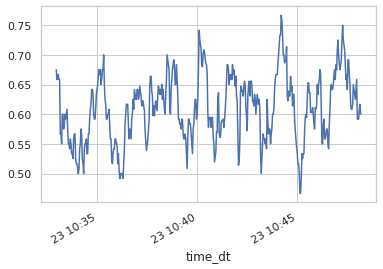

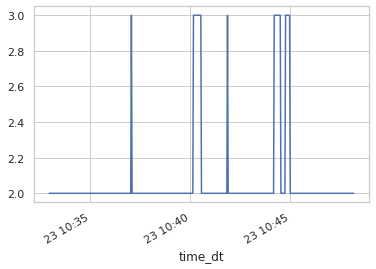

In [6]:
parse_skip_mins = 5

def parse_logger_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['time', ])
    # skip 5 minutes
    df = df[df['time_dt'] > df['time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['ready_count']
    # set index to the time
    df = df.set_index('time_dt')
    return df


df = parse_logger_file(logger_file_list[0])
display(df.head())

plt.figure()
df['conc_window_average'].plot()
plt.figure()
df['ready_count'].plot()

## Analyze Experiment-By-Experiment Results

100%|██████████| 55/55 [00:00<00:00, 60.52it/s]


,conc_window_average_mean,arrival_rate,average_ready_count
0,0.610357,1.0,2.067834
1,0.659373,3.0,5.869757
2,0.678942,5.0,8.809735
3,0.688594,7.0,12.549889
4,0.692535,9.0,15.252772


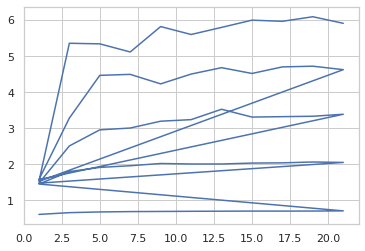

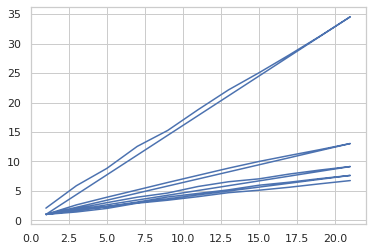

In [7]:
results_arr = []
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    arrival_rate = df['rps'][0]

    results_arr.append({
        'conc_window_average_mean': df['conc_window_average'].mean(),
        'arrival_rate': arrival_rate,
        'average_ready_count': df['ready_count'].mean()
    })

df_logger_result = pd.DataFrame(data=results_arr)
display(df_logger_result.head())

# TODO: After adding cc to the experiment results, plot this after grouping
plt.figure()
plt.plot(df_logger_result['arrival_rate'], df_logger_result['conc_window_average_mean'])
plt.figure()
plt.plot(df_logger_result['arrival_rate'], df_logger_result['average_ready_count'])

## Analyze Merged Results

100%|██████████| 55/55 [00:00<00:00, 55.53it/s]


,ready_count,total_conc,conc_window_average,time,rps
lambda_over_n,,,,,
0.333333,3.000000,0.967742,0.669176,1.611417e+09,1.000000
0.428571,7.000000,3.350000,0.732262,1.611417e+09,3.000000
0.500000,4.421931,2.762813,0.636863,1.611417e+09,2.210965
0.529412,17.000000,10.000000,0.754800,1.611421e+09,9.000000
0.538462,13.000000,8.801105,0.691654,1.611420e+09,7.000000


Text(0, 0.5, 'measured concurrency')

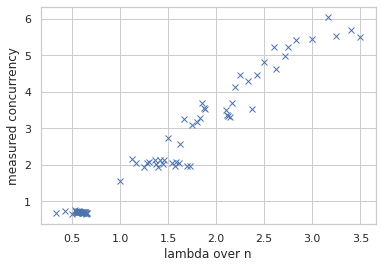

In [8]:
df_logger_merged = pd.DataFrame()
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    df_logger_merged = df_logger_merged.append(df)


tmpdf = df_logger_merged.groupby('lambda_over_n').mean()
display(tmpdf.head())
# let's analyze the relationship between conc_window_average and lambda_over_n
plt.plot(tmpdf.index, tmpdf['conc_window_average'], 'x')
plt.xlabel('lambda over n')
plt.ylabel('measured concurrency')

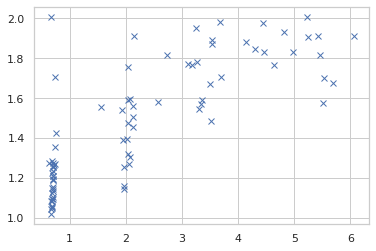

In [9]:
# this tries to model average service time as a function of average number of requests in each container
plt.plot(tmpdf['conc_window_average'], tmpdf['conc_window_average'] / tmpdf.index, 'x')

Now, let's try and see we can see any relationship between $\lambda/N$ and the $\mu$ and $\sigma$ of the measured concurrency.

In [10]:
tmp_res = []
for lambda_over_n in df_logger_merged['lambda_over_n'].unique():
    sub_df = df_logger_merged.loc[df_logger_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'conc_window_average_mean': np.mean(sub_df['conc_window_average']),
            'conc_window_average_std': np.std(sub_df['conc_window_average']),
        })
    # if len(sub_df) > 400:
    #     plt.figure()
    #     plt.hist(sub_df['conc_window_average'], bins=20)

tmpdf = pd.DataFrame(data=tmp_res)

average std to mean 0.07910337417479094


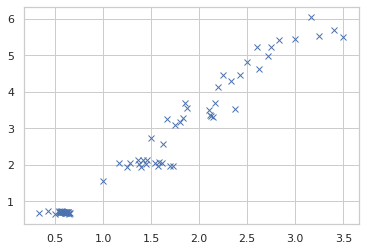

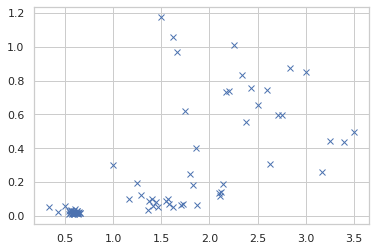

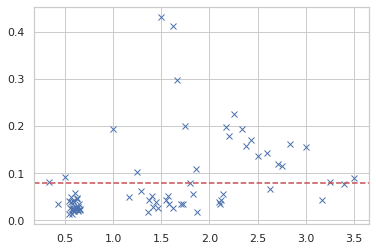

In [21]:
conc_avg_std_to_mean = (tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean']).mean()
print("average std to mean", conc_avg_std_to_mean)

plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean'], 'x')
plt.axhline(y=conc_avg_std_to_mean, c='r', ls='--')

# Developing Analysis of Requests Results

In [23]:
reqs_file_list = glob.glob(results_reqs_glob)
reqs_file_list.sort()

In [29]:
def parse_logger_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['client_start_time', 'client_end_time' ])
    # skip 5 minutes
    df = df[df['client_start_time_dt'] > df['client_start_time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    # df['lambda_over_n'] = df['rps'] / df['start_ready_count']
    # # set index to the time
    df = df.set_index('client_start_time_dt')
    return df


df = parse_logger_file(reqs_file_list[0])
display(df.head())

,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,rps,client_end_time_dt
client_start_time_dt,,,,,,,,
2021-01-23 10:32:55.813493,1.611416e+09,1.611416e+09,1.111761,1,1,True,1.0,2021-01-23 10:32:56.925255
2021-01-23 10:32:57.889341,1.611416e+09,1.611416e+09,1.051129,2,3,True,1.0,2021-01-23 10:32:58.940470
2021-01-23 10:32:57.611906,1.611416e+09,1.611416e+09,1.727633,1,2,True,1.0,2021-01-23 10:32:59.339540
2021-01-23 10:32:58.584116,1.611416e+09,1.611416e+09,1.050645,3,1,True,1.0,2021-01-23 10:32:59.634761
2021-01-23 10:32:59.776517,1.611416e+09,1.611416e+09,1.150385,1,2,True,1.0,2021-01-23 10:33:00.926902
